<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Phase Curve of Solar System Objects</b> <br>
Contact authors: Christina Williams and Yumi Choi<br>
Last verified to run: <i>2023-07-dd</i> <br>
LSST Science Piplines version: Weekly <i>2023_21</i> <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** Investigate the derivation of phase curves for solar systme objects and explore DP0.3-provided phase curve parameters. 

**Skills:** Use various TAP tables, including joining multiple tables. Derive and compare phase curves. Explore accuracy of the phase curve parameters as a function of obervations.

**LSST Data Products:** TAP tables dp03_catalogs.SSObject, dp03_catalogs.MPCORB, dp03_catalogs.DiaSource, dp03_catalogs.SSSource

**Packages:** numpy, scipy, pandas, matplotlib, seaborn, lsst.rsp

**Credit:**
Inspired by a notebook develeoped by _Meg (need full name!!)_. Standalone functions for phase curve fitting are provided by Pedro Bernardinelli. References: <a href="https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract">Muinonen et al. (2010)</a> and <a href="http://astronotes.co.uk/blog/2018/05/28/determining-the-h-g-parameters-of-atlas-asteroid-phase-curves.html">David Young's webpage.</a>

**Get Support:**
Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

In [211]:
# general python packages
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# LSST package for TAP queries
from lsst.rsp import get_tap_service

### 1.2 Define Functions and Parameters

Set up some plotting defaults:

In [203]:
plt.style.use('tableau-colorblind10')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
params = {'axes.labelsize': 15,
          'font.size': 15,
          'legend.fontsize': 12}
plt.rcParams.update(params)

To supress NumPy RuntimeWarning

In [368]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Define functions for phase curvit fitting:

In [131]:
# Constants values taken from sbpy (https://sbpy.org) for convenience
A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2, 3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2, 1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1, 1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]

phi_1 = CubicSpline(alpha_12, phi_1_sp, bc_type=((1,phi_1_derivs[0]),(1,phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp, bc_type=((1,phi_2_derivs[0]),(1,phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp, bc_type=((1,phi_3_derivs[0]),(1,phi_3_derivs[1])))

In [132]:
def HG_model(phase, params):
    """
    Compute HG model phase curve for a given set 
    of parameters. The simplest 2-parameter model.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray     
    """
    
    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)
    
    W = np.exp(-90.56 * tan_ah * tan_ah)    
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)
    
    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina
    
    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))
    
    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L
    
    return params[0] - 2.5*np.log10((1-params[1])* phi_1 + (params[1]) * phi_2) 

In [133]:
def HG1G2_model(phase, params):
    """
    Compute HG1G2 model phase curve for a given set 
    of parameters. This is a 3-parameter model, which works best
    when sufficiently long phaseangle coverage is available.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray     
    """

    tan_ah = np.tan(phase/2)

    phi_1_ev = phi_1(phase)  
    phi_2_ev = phi_2(phase)  
    phi_3_ev = phi_3(phase)  

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6*phase[msk]/np.pi 
    phi_2_ev[msk] = 1- 9 * phase[msk]/(5*np.pi)

    phi_3_ev[phase > np.pi/6] = 0

    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev + params[2] * phi_2_ev + (1-params[1]-params[2]) * phi_3_ev)

In [134]:
def HG12_model(phase, params): 
    """
    Compute HG12 model phase curve for a given set 
    of parameters. This is a 2-parameter, simplified version
    of HG1G2 model, which is useful when phaseangle coverage is shorter. 

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray
    """
    
    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162 
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164  
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

In [224]:
def wd(params, mag, phase, mag_err, model):
    """
    Compute weighted deviation for a given model.
    """
    
    pred = model(phase, params)
    
    return (mag - pred)/mag_err

In [225]:
def fit(mag, phase, sigma, model=HG12_model, params=[0.1]):
    """
    Fit phase curve for given observations to a designated model.
    
    Parameters
    ----------
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in degrees
    sigma: ndarray
        uncertainty in magnitude
    model: function (default=HG12_model)
        phase curve model function
    params: list (default=[0.1])
        phase curve paramters

    Returns
    -------
    sol: tuple
        best-fit solution
    """
    
    phase = np.deg2rad(phase)
    sol = leastsq(wd, [mag[0]] + params,  (mag, phase, sigma, model), full_output = True)

    return sol

In [209]:
def fit_models(reducedMag, magSigma, phaseAngle, verbose=False):
    """
    Fit phase curves for given observations to 3 different models.
    
    Parameters
    ----------
    reducedMag: ndarray
        reduced magnitude
    magSigma: ndarray
        uncertainty in magnitude
    phaseAngle: ndarray
        phase angle in degrees

    Returns
    -------
    solutions: dict
        Best-fit solutions for each model
    """

    # We fit observations using each one of the HG, HG12 and HG1G2 models 
    # and store the resulting solutions in a dictionary of dictionaries.
    # Save np.nan values when the fit has not been converged
    solutions = {}

    # Let's do HG first
    sol_HG = fit(reducedMag, phaseAngle, magSigma, model=HG_model)

    solutions['HG'] = {}  
    try:
        solutions['HG']['chi2'] = np.sum(sol_HG[2]['fvec']**2)
        solutions['HG']['H'] = sol_HG[0][0]
        solutions['HG']['G'] = sol_HG[0][1]
        solutions['HG']['H_err'] = np.sqrt(sol_HG[1][0,0])
        solutions['HG']['G_err'] = np.sqrt(sol_HG[1][1,1])
        solutions['HG']['cov'] = sol_HG[1]
    except TypeError:
        if verbose:
            print('HG model is not converging')
        solutions['HG']['chi2'] = np.nan
        solutions['HG']['H'] = np.nan
        solutions['HG']['G'] = np.nan
        solutions['HG']['H_err'] = np.nan
        solutions['HG']['G_err'] = np.nan
        solutions['HG']['cov'] = np.nan            

    # Now HG12
    sol_HG12 = fit(reducedMag, phaseAngle, magSigma, model=HG12_model)

    solutions['HG12'] = {}
    try:
        solutions['HG12']['chi2'] = np.sum(sol_HG12[2]['fvec']**2)
        solutions['HG12']['H'] = sol_HG12[0][0]
        solutions['HG12']['G12'] = sol_HG12[0][1]
        solutions['HG12']['H_err'] = np.sqrt(sol_HG12[1][0,0])
        solutions['HG12']['G12_err'] = np.sqrt(sol_HG12[1][1,1])
        solutions['HG12']['cov'] = sol_HG12[1]
    except TypeError:
        if verbose:
            print('HG12 model is not converging')
        solutions['HG12']['chi2'] = np.nan
        solutions['HG12']['H'] = np.nan
        solutions['HG12']['G12'] = np.nan
        solutions['HG12']['H_err'] = np.nan
        solutions['HG12']['G12_err'] = np.nan
        solutions['HG12']['cov'] = np.nan

    # Finally, HG1G2 - note this returns an extra parameter
    sol_HG1G2 = fit(reducedMag, phaseAngle, magSigma, model=HG1G2_model, params=[0.1, 0.1])
    
    solutions['HG1G2'] = {}
    try:
        solutions['HG1G2']['chi2'] = np.sum(sol_HG1G2[2]['fvec']**2)
        solutions['HG1G2']['H'] = sol_HG1G2[0][0]
        solutions['HG1G2']['G1'] = sol_HG1G2[0][1]
        solutions['HG1G2']['G2'] = sol_HG1G2[0][2]
        solutions['HG1G2']['H_err'] = np.sqrt(sol_HG1G2[1][0,0])
        solutions['HG1G2']['G1_err'] = np.sqrt(sol_HG1G2[1][1,1])
        solutions['HG1G2']['G2_err'] = np.sqrt(sol_HG1G2[1][2,2])
        solutions['HG1G2']['cov'] = sol_HG1G2[1]
    except TypeError:
        if verbose: 
            print('HG1G2 model is not converging')
        solutions['HG1G2']['chi2'] = np.nan
        solutions['HG1G2']['H'] = np.nan
        solutions['HG1G2']['G1'] = np.nan
        solutions['HG1G2']['G2'] = np.nan
        solutions['HG1G2']['H_err'] = np.nan
        solutions['HG1G2']['G1_err'] = np.nan
        solutions['HG1G2']['G2_err'] = np.nan
        solutions['HG1G2']['cov'] = np.nan
        
    return solutions

## 2. Querying the DP0.3 tables and fitting phase curves of SS objects

### 2.1 Create the Rubin TAP Service Client

Get an instance of the TAP service, and assert that it exists.

In [4]:
service = get_tap_service("ssotap")
assert service is not None

### 2.2 Querying the DP0.3 SSObject and MPCORB catalogs

For phase curve fitting, we need apparent magnitudes & uncertainties, phase angles, topocentric (tdist) and heliocentric (rdist) distances.

_In the ssObjectTable, the column G12 is correct in that the final table
should contain the parameter G12, however, the existing version of the column
actually contains parameter G (and therefore should be compared to the HG_model
not HG12 model. The plan is to replace the contents of G12 column with actual G12
fit parameters in the final version. This needs to be checked before release._ 


In [299]:
# To keep a reasonable run time for this tutorial, we select objects with number of objects > 3000 and arc > 3000 days. 
nobs_thrh = '3000' # Number of LSST observations
arc_thrh = '3000' # Arc of LSST observations; units in days

In [301]:
# Getting a table of columns for unique objects with number of observations > nobs_thrh and arc longer than arc_thrh
query = """
SELECT 
    mpc.ssObjectId, mpc.q, mpc.mpcG, mpc.mpcH,
    sso.arc, sso.numObs, 
    sso.uH, sso.uHerr, sso.uG12, sso.uG12err, sso.uH_uG12_Cov,
    sso.gH, sso.gHerr, sso.gG12, sso.gG12err, sso.gH_gG12_Cov,
    sso.rH, sso.rHerr, sso.rG12, sso.rG12err, sso.rH_rG12_Cov,
    sso.iH, sso.iHerr, sso.iG12, sso.iG12err, sso.iH_iG12_Cov,
    sso.zH, sso.zHerr, sso.zG12, sso.zG12err, sso.zH_zG12_Cov,
    sso.yH, sso.yHerr, sso.yG12, sso.yG12err, sso.yH_yG12_Cov
FROM 
    dp03_catalogs.MPCORB as mpc 
INNER JOIN dp03_catalogs.SSObject as sso 
ON mpc.ssObjectId = sso.ssObjectId 
WHERE sso.numObs > {} AND sso.arc > {} ORDER by sso.ssObjectId 
""".format(nobs_thrh, arc_thrh)

df_uniqueObj = service.search(query).to_table()
df_uniqueObj

ssObjectId,q,mpcG,mpcH,arc,numObs,uH,uHerr,uG12,uG12err,uH_uG12_Cov,gH,gHerr,gG12,gG12err,gH_gG12_Cov,rH,rHerr,rG12,rG12err,rH_rG12_Cov,iH,iHerr,iG12,iG12err,iH_iG12_Cov,zH,zHerr,zG12,zG12err,zH_zG12_Cov,yH,yHerr,yG12,yG12err,yH_yG12_Cov
,AU,,mag,d,,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2
int64,float64,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
-9160335891119196734,2.18848,0.15,14.38,3341.0935,3010,15.974593,0.003538737,0.13540827,0.003439854,1.1818178e-05,14.655099,0.0008827314,0.12975127,0.0007974115,6.83158e-07,14.1867895,0.00061638607,0.13442001,0.0005615722,3.3507138e-07,14.069777,0.00073934335,0.13603345,0.0006567771,4.7111925e-07,14.0716505,0.0013131155,0.14293106,0.0012290746,1.5462429e-06,14.06428,0.0016321399,0.14187744,0.0015170963,2.399269e-06
-9122550463736920866,2.90333,0.15,16.95,3541.1165,3186,18.779285,0.08071087,0.55770034,0.15304966,0.011904205,17.224314,0.007449597,0.12733981,0.007642086,5.504581e-05,16.761005,0.0045596617,0.13943394,0.004886307,2.1405353e-05,16.628132,0.0067277593,0.12562878,0.006778814,4.424232e-05,16.602016,0.018299524,0.10527938,0.01896701,0.00033826812,16.698843,0.03555247,0.26963112,0.047310278,0.0016391794
-9104426139280684352,1.99854,0.15,18.82,3295.7324,3105,20.688686,0.10572543,0.11616846,0.09167436,0.009585608,19.197058,0.006623197,0.13803145,0.0057763476,3.7577836e-05,18.547478,0.0035120018,0.1369316,0.0030281474,1.041355e-05,18.346308,0.0046819383,0.1363627,0.0040087253,1.8422603e-05,18.379213,0.009388997,0.117804505,0.0089924615,8.242993e-05,18.44825,0.017234057,0.19176692,0.016526204,0.00027978275
-9055761814619818019,2.6703,0.15,16.46,3585.1802,3260,18.12982,0.04630982,0.23237284,0.060211547,0.002703436,16.749468,0.0046555423,0.14125136,0.0050033457,2.2397873e-05,16.274412,0.0026356217,0.1404339,0.0028890504,7.2778735e-06,16.161871,0.00361793,0.14957283,0.0038542263,1.3404647e-05,16.15884,0.008501896,0.1462766,0.009115202,7.361746e-05,16.166477,0.015653847,0.1860451,0.017875474,0.00027043364
-8861604831036051458,33.90530835,0.15,6.39,3467.649,3850,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
-8824888193414498318,2.79174,0.15,14.66,3589.2207,3064,16.57724,0.009231824,0.14588262,0.009154001,8.1793594e-05,15.035247,0.001580692,0.13509357,0.0014482355,2.2383845e-06,14.388222,0.00095599465,0.13785343,0.0008837154,8.263155e-07,14.187011,0.0011644945,0.13704121,0.00106577,1.2170949e-06,14.237688,0.0018251783,0.13364868,0.0017882781,3.1707214e-06,14.248958,0.0025201426,0.14867143,0.0024787793,6.0366274e-06
-8775539482313645283,3.09719,0.15,16.91,3545.956,3004,18.715216,0.07829525,0.56085956,0.14959951,0.011247727,17.206036,0.006490891,0.15646611,0.0072020767,4.483e-05,16.724682,0.004724906,0.14349854,0.0052410667,2.3805394e-05,16.597546,0.006596554,0.1357407,0.00703722,4.493383e-05,16.60387,0.016017416,0.15739147,0.018234806,0.0002818353,16.652065,0.03338243,0.24090612,0.0446976,0.00145154
-8760000674864496854,2.81679,0.15,15.35,3516.2617,3141,17.245808,0.019255549,0.1260429,0.020576926,0.00037200734,15.73284,0.0026378245,0.14366013,0.0027296534,6.9249477e-06,15.085377,0.0013993066,0.14536168,0.0014744721,1.9710633e-06,14.884882,0.0015459601,0.14542618,0.0015926966,2.3672526e-06,14.936535,0.0029964321,0.1423352,0.003379272,9.595615e-06,14.944049,0.0047305888,0.15746163,0.0051825684,2.3284798e-05


### 2.3 Querying the DP0.3 DiaSource and SSSource catalogs

Getting time series data for the unique objects selected above. This query usually takes ~30 sec.

In [302]:
query = """
SELECT 
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magSigma, dia.filter, dia.midPointTai, 
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM 
    dp03_catalogs.DiaSource as dia
INNER JOIN 
    dp03_catalogs.SSSource as sss
ON 
    dia.diaSourceId = sss.diaSourceId
WHERE 
    dia.ssObjectId 
    IN (
        SELECT sso.ssObjectId
        FROM dp03_catalogs.SSObject as sso 
        WHERE sso.numObs > {} AND sso.arc > {}
        )
ORDER by dia.ssObjectId 
""".format(nobs_thrh, arc_thrh)

df_indivObs = service.search(query).to_table()
df_indivObs

ssObjectId,diaSourceId,mag,magSigma,filter,midPointTai,phaseAngle,topocentricDist,heliocentricDist
,,,,,d,deg,AU,AU
int64,int64,float32,float32,str1,float64,float32,float32,float32
-9160335891119196734,-4714752590257754695,17.715965,0.00507329,y,61088.18156689308,3.882442,1.6952062,2.6727955
-9160335891119196734,8658493076713800913,17.713116,0.005512223,y,61088.20183066884,3.8867426,1.6952555,2.6728256
-9160335891119196734,4916825279755151979,17.90116,0.003526958,z,61096.175285391946,6.33933,1.7237068,2.6845658
-9160335891119196734,-9017304948609349146,17.836683,0.0021887536,r,61087.26830092715,3.7129395,1.6931158,2.6714406
-9160335891119196734,-4424267694392087797,17.86899,0.002020167,r,61089.28010348667,4.1327105,1.6980523,2.6744227
-9160335891119196734,-2764579693930997294,17.83147,0.0021406596,r,61087.26874901561,3.7130158,1.6931168,2.6714413
-9160335891119196734,7902761923550661644,17.894371,0.0033611385,z,61096.174839292136,6.3391657,1.7237047,2.684565
-9160335891119196734,9009871121378705816,17.816067,0.0017486681,r,61086.19705696757,3.5645716,1.6909616,2.6698487


Double check if the number of unique objects in df_indivObs is identical to that of df_uniqueObj.

In [303]:
assert len(df_uniqueObj) == len(np.unique(df_indivObs['ssObjectId']))

### 2.4 Fitting phase curve per filter per unique object using three different fitting functions

Compute reduced magnitude for each observation and add it as a column to the df_indivObs. Reduced magnitude is normalized apparent magnitude of an asteroid to make as if it is observed at 1 AU from both the Sun and the Earth.

In [304]:
dmag = -5. * np.log10(df_indivObs['topocentricDist']*df_indivObs['heliocentricDist'])
reduced_mag = df_indivObs['mag'] + dmag

df_indivObs.add_column(reduced_mag, name='reducedMag')

Fitting phase curve per filter per unique object using three different fitting functions. This cell takes ~6 min for 269 unique objects with the medium container size.

In [210]:
fitted_array = []

for iobj in df_uniqueObj['ssObjectId']:
    idx = df_indivObs['ssObjectId'] == iobj
    df_tmp = df_indivObs[idx]
    filts = np.unique(df_tmp['filter'])
    for ifilt in filts:
        idx_filt = df_tmp['filter'] == ifilt
        nobs_ifilt = len(df_tmp[idx_filt])
    
        # number of observations needs to be greater than the number of fit parameter, which is 3.
        if nobs_ifilt > 3:
            x_fitted = fit_models(df_tmp['reducedMag'][idx_filt], 
                                  df_tmp['magSigma'][idx_filt], 
                                  df_tmp['phaseAngle'][idx_filt]
                                  )
            fitted_array.append([iobj, ifilt, x_fitted])

/tmp/ipykernel_39382/3040247281.py:20: RuntimeWarning: invalid value encountered in log10
  return params[0] - 2.5 * np.log10(params[1] * phi_1_ev + params[2] * phi_2_ev + (1-params[1]-params[2]) * phi_3_ev)


In [178]:
results = pd.DataFrame(fitted_array)
results.columns=['ssObjectId', 'fname', 'fit_param']

# Uncomment the line below if you want to display the contents of the model fit return:
# print(x_fitted)

{'HG': {'chi2': 592.8137277294526, 'H': 15.226488795158026, 'G': 0.15328315316260244, 'H_err': 0.0032616333420818645, 'G_err': 0.0035532966558325997, 'cov': array([[1.06382521e-05, 1.09827224e-05],
       [1.09827224e-05, 1.26259171e-05]])}, 'HG12': {'chi2': 599.2498879920878, 'H': 15.291902952787211, 'G12': 0.6260186504286682, 'H_err': 0.0012408023620292551, 'G12_err': 0.01017845207459367, 'cov': array([[1.53959050e-06, 6.86533674e-06],
       [6.86533674e-06, 1.03600887e-04]])}, 'HG1G2': {'chi2': 546.3033224890617, 'H': 15.211701850730964, 'G1': 0.5028774174939458, 'G2': 0.2030221353590074, 'H_err': 0.010810356115118767, 'G1_err': 0.01729275519955086, 'G2_err': 0.006873607673118528, 'cov': array([[ 1.16863799e-04,  1.64564359e-04, -4.36248086e-05],
       [ 1.64564359e-04,  2.99039382e-04, -1.06802883e-04],
       [-4.36248086e-05, -1.06802883e-04,  4.72464824e-05]])}}


Converting the fit parameter dictionary to individual columns in a pandas dataframe makes it easy to read each parameters. But it also takes some time. It might be great if we can come up with a more efficient way of storing and accessing all the necessary columns for making plots and doing analysis in later parts of this tutorial.

In [179]:
results = results[['ssObjectId', 'fname']].join(pd.json_normalize(results.fit_param))

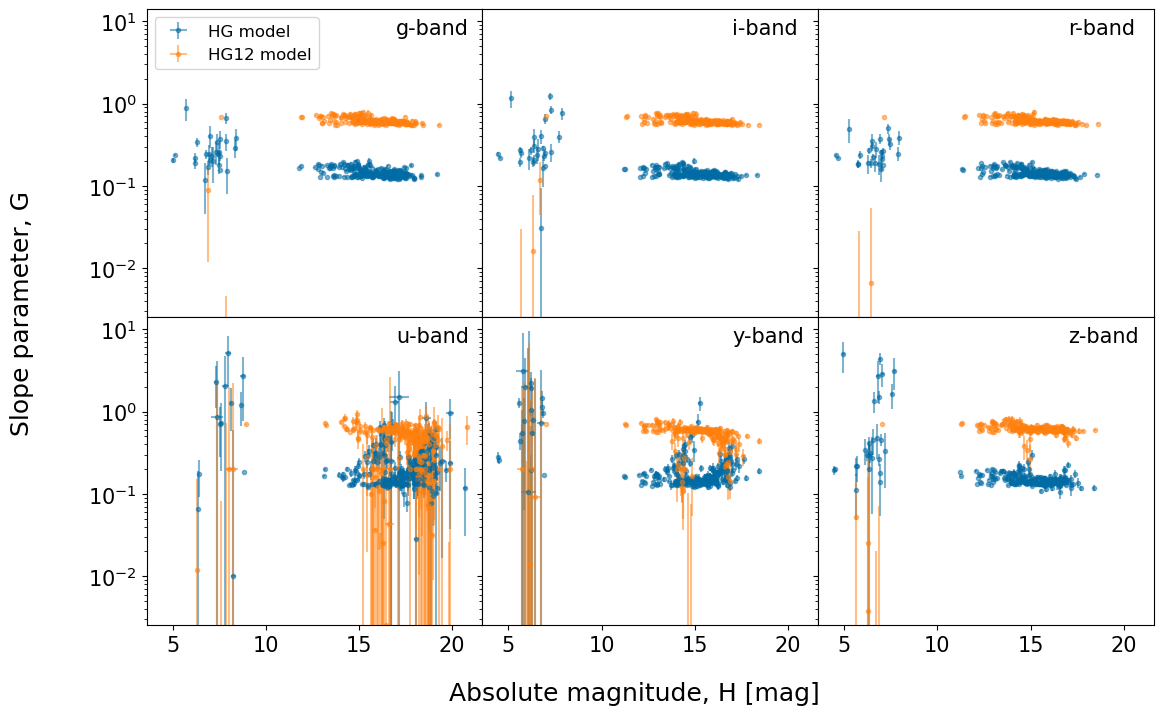

In [305]:
# Plot the G vs H paramters from the two 2-parameter model fits: HG and HG12
fig = plt.figure(figsize=(13,8))
gs = fig.add_gridspec(2, 3, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

for i,ifilt in enumerate(filts):
    axs[i].errorbar(results[results.fname==ifilt]['HG.H'],
                    results[results.fname==ifilt]['HG.G'], 
                    xerr=results[results.fname==ifilt]['HG.H_err'],
                    yerr=results[results.fname==ifilt]['HG.G_err'],
                    fmt='.', alpha=0.5, label='HG model')
    axs[i].errorbar(results[results.fname==ifilt]['HG12.H'],
                    results[results.fname==ifilt]['HG12.G12'], 
                    xerr=results[results.fname==ifilt]['HG12.H_err'],
                    yerr=results[results.fname==ifilt]['HG12.G12_err'], 
                    fmt='.', alpha=0.5, label='HG12 model')
        
    plt.yscale('log')
    axs[i].text(17, 7, ifilt+'-band')

fig.supxlabel('Absolute magnitude, H [mag]')
fig.supylabel('Slope parameter, G')
axs[0].legend(loc=2)

Text(0.5, 1.0, 'ssObjectId = -9122550463736920866')

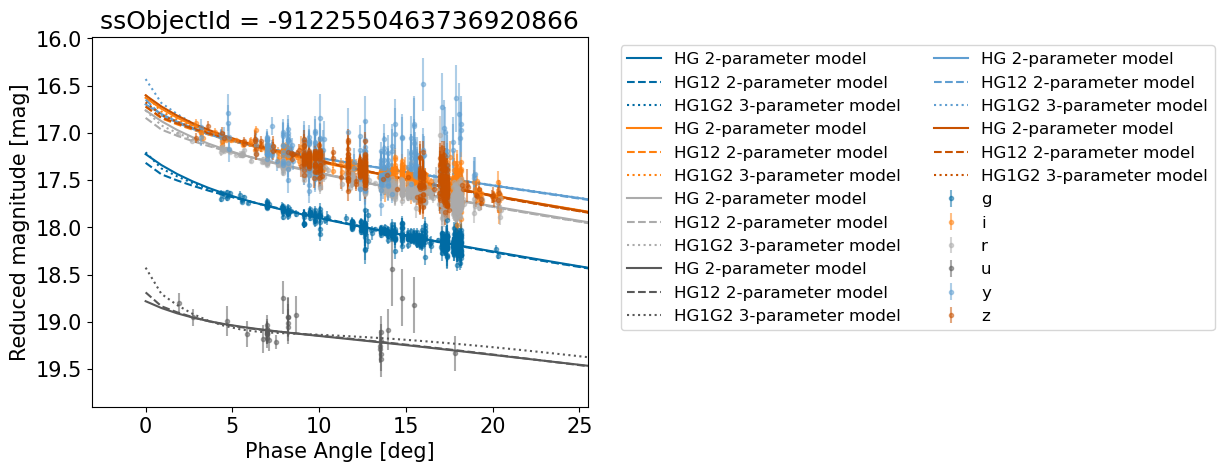

In [343]:
# Plot example phase curves in u,g,r,i,z,y for a single object
iObj = 1 # you can pick any integer number between 0 and 268
sId = df_uniqueObj['ssObjectId'][iObj]
df_tmp = df_indivObs[df_indivObs['ssObjectId'] == sId]
phases = np.linspace(0,90,100)

for i,ifilt in enumerate(filts):
    idx = df_tmp['filter'] == ifilt
    
    # Plot observations
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx], yerr=df_tmp['magSigma'][idx],
                 fmt='.', color=colors[i], alpha=0.5, label=ifilt)

    # Plot HG model
    HG_mag = HG_model(np.deg2rad(phases),
                     [results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG.H'].values,
                      results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG.G'].values])
    plt.plot(phases, HG_mag, color=colors[i], label ='HG 2-parameter model')
    
    #Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                         [results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG12.H'].values,
                          results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG12.G12'].values])
    plt.plot(phases, HG12_mag, color=colors[i], linestyle='--',  label ='HG12 2-parameter model')
    
    # Plot HG1G2 model 
    HG1G2_mag = HG1G2_model(np.deg2rad(phases), 
                           [results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG1G2.H'].values,
                            results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG1G2.G1'].values,
                            results[(results.ssObjectId == sId) & (results.fname == ifilt)]['HG1G2.G2'].values])
    plt.plot(phases, HG1G2_mag, color=colors[i], linestyle='dotted',  label ='HG1G2 3-parameter model')
    
plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=2)
plt.title('ssObjectId = %d' % sId)

### 2.5 Explore phase curve fit uncertainty

Text(0.5, 1.0, 'ssObjectId = -9122550463736920866')

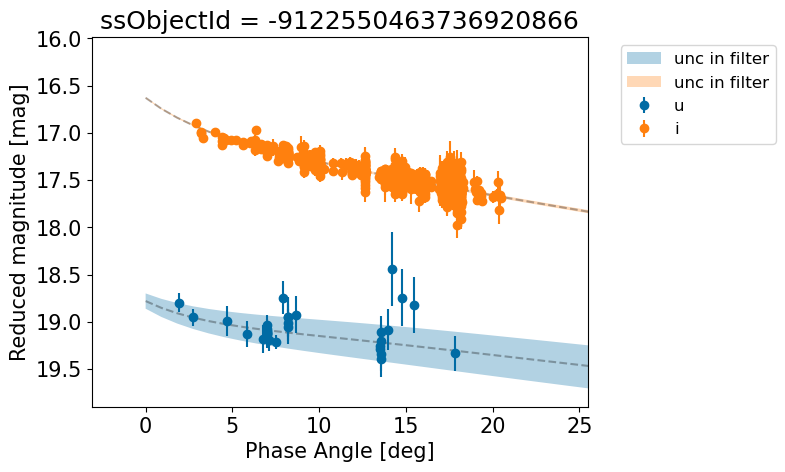

In [353]:
# Note: df_uniqueObj contains the model params and errors

# For the same unique object picked in the above cell, we delve into u- and i-filters 
# to demonstrate fit uncertainty in a sharp contrast

for ifilt in ['u', 'i']:
    idx = df_tmp['filter'] == ifilt
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx], yerr=df_tmp['magSigma'][idx],
                 fmt='o', label=ifilt, zorder=10)

    # Grab the phase curve parameters for the HG12 model stored in SSObject Table.
    # In priciple, these parameters should be identical to those derived for the HG12 model above in this NB.
    HG_mag_sso = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][iObj], df_uniqueObj[ifilt+'G12'][iObj]])
    plt.plot(phases, HG_mag_sso, 'k--', alpha=0.3)
    
    # Compute min/max values in reduced mag at each phase angle
    p1 = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][iObj] + df_uniqueObj[ifilt+'Herr'][iObj], 
                                       df_uniqueObj[ifilt+'G12'][iObj] + df_uniqueObj[ifilt+'G12err'][iObj]])

    p2 = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][iObj] - df_uniqueObj[ifilt+'Herr'][iObj], 
                                       df_uniqueObj[ifilt+'G12'][iObj] + df_uniqueObj[ifilt+'G12err'][iObj]])

    p3 = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][iObj] + df_uniqueObj[ifilt+'Herr'][iObj], 
                                       df_uniqueObj[ifilt+'G12'][iObj] - df_uniqueObj[ifilt+'G12err'][iObj]])

    p4 = HG_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'H'][iObj] - df_uniqueObj[ifilt+'Herr'][iObj], 
                                       df_uniqueObj[ifilt+'G12'][iObj] - df_uniqueObj[ifilt+'G12err'][iObj]])
    
    HG_magHigh = np.maximum(np.maximum(p1, p2), np.maximum(p3, p4))
    HG_magLow = np.minimum(np.minimum(p1, p2), np.minimum(p3, p4))
    
    plt.fill_between(phases, HG_magLow, HG_magHigh, alpha=0.3)

plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)

Here we compare the typical apparent magnitude uncertainties per band to see how that impacts the fit. 

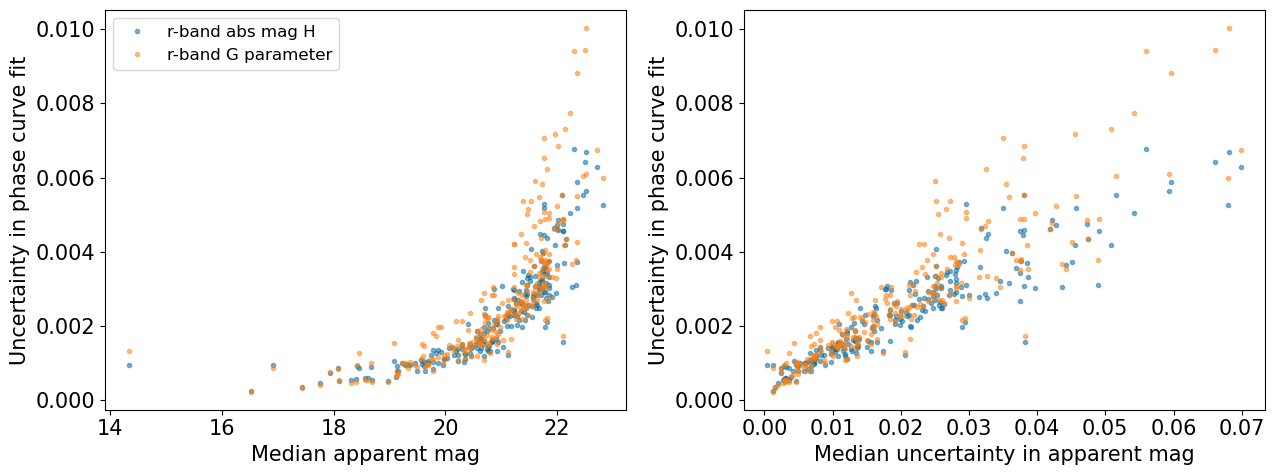

In [380]:
# Compute meadian apparent magnitude and its median uncertainty in r-filter in this example
mag_med = []
magSigma_med = []
ifilt = 'r'
    
for iobj in df_uniqueObj['ssObjectId']:
    idx = df_indivObs['ssObjectId'] == iobj
    df_tmp = df_indivObs[idx]
    idx_filt = df_tmp['filter'] == ifilt
    
    mag_med.append(np.median(df_tmp['mag'][idx_filt]))
    magSigma_med.append(np.median(df_tmp['magSigma'][idx_filt]))
    
# Plot phase curve parameters vs. median apparent magnitude and its median uncertainty
plt.figure(figsize=(13,5))

plt.subplot(121)
plt.plot(mag_med, df_uniqueObj[ifilt+'Herr'], '.', alpha=.5, label=ifilt+'-band abs mag H')
plt.plot(mag_med, df_uniqueObj[ifilt+'G12err'], '.', alpha=.5, label=ifilt+'-band G parameter')
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median apparent mag')
plt.legend()

plt.subplot(122)
plt.plot(magSigma_med, df_uniqueObj[ifilt+'Herr'],'.',alpha=.5)
plt.plot(magSigma_med, df_uniqueObj[ifilt+'G12err'],'.',alpha=.5)
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median uncertainty in apparent mag')

plt.tight_layout()

Clean up all before moving on to population study

In [ ]:
del df_uniqueObj, df_indivObs, results

## 3. Population study of measurements of the SS objects DP0.3 tables 

Now that we have demonstrated how to fit a phase curve to DP0.3 data, experimented with 3 different models, and compared those to the automated fits that are stored in the SSObject Table, we look at the population in aggregate: population study with the fit results (e.g., how the fit values differ due to number of observations, or for near/far or bright/faint objects).

In [35]:
# First, re-query for a table of columns for unique objects with number of observations and arc over larger
# dynamic range than before, and add some extra criteria of use in assessing uncertainty. To decide: is
# this second query is necessary, or should we adapt the earlier query and sub-sample it with 
# nobs_thrh and arc_thrh >3000, since the query takes a long time (~5 min).

nobs_thrh = 50 
arc_thrh = 100

query = """
SELECT TOP 50000
    mpc.ssObjectId, mpc.q, sso.arc, sso.numObs, 
    sso.uH, sso.uHerr, sso.uG12, sso.uG12err, 
    sso.gH, sso.gHerr, sso.gG12, sso.gG12err, 
    sso.rH, sso.rHerr, sso.rG12, sso.rG12err, 
    sso.iH, sso.iHerr, sso.iG12, sso.iG12err, 
    sso.zH, sso.zHerr, sso.zG12, sso.zG12err, 
    sso.yH, sso.yHerr, sso.yG12, sso.yG12err,
    sso.uNdata, sso.gNdata, sso.rNdata, 
    sso.iNdata, sso.zNdata, sso.yNdata
FROM 
    dp03_catalogs.MPCORB as mpc 
INNER JOIN dp03_catalogs.SSObject as sso 
ON mpc.ssObjectId = sso.ssObjectId 
WHERE sso.numObs > {} AND sso.arc > {} 
""".format(nobs_thrh, arc_thrh)

res = service.search(query).to_table().to_pandas()
res

,ssObjectId,q,arc,numObs,uH,uHerr,uG12,uG12err,gH,gHerr,...,yH,yHerr,yG12,yG12err,uNdata,gNdata,rNdata,iNdata,zNdata,yNdata
0,3369984299447,1.84472,3578.774902,103,NaN,NaN,NaN,NaN,20.742580,0.054457,...,NaN,NaN,NaN,NaN,0,17,48,25,11,0
1,5992863104062,2.72664,3257.708984,131,NaN,NaN,NaN,NaN,19.393185,0.073894,...,NaN,NaN,NaN,NaN,0,19,59,43,10,0
2,10660550296725,2.05163,3488.881104,86,NaN,NaN,NaN,NaN,20.376009,0.057646,...,NaN,NaN,NaN,NaN,0,14,38,21,0,0
3,14153868090287,1.98374,2511.029297,52,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,25,19,0,0
4,14169511631100,2.71217,3426.781738,402,19.691935,0.054631,0.601672,0.249413,18.332722,0.009417,...,17.730972,0.028723,0.312994,0.063289,8,50,111,108,87,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,213371773026874092,2.33110,3371.955078,398,16.593916,0.010958,0.138579,0.013322,15.071165,0.003679,...,14.253757,0.004259,0.135139,0.004401,18,35,85,107,84,69
49996,213374132615207572,2.80611,3560.152100,355,17.104940,0.032077,0.154963,0.049602,15.782082,0.006198,...,15.196302,0.015357,0.138053,0.017668,14,26,84,93,82,56
49997,213374164079848636,2.30861,3457.960693,152,NaN,NaN,NaN,NaN,19.868607,0.083064,...,20.658552,6.098199,7.958487,52.005821,0,30,61,39,17,5
49998,213376196501138278,2.33629,3402.708740,404,19.863565,0.110225,0.785352,0.319622,18.138954,0.007549,...,17.313629,0.024830,0.155452,0.036339,5,39,117,115,68,60


### 3.1 Distribution of H and G parameters in all six filters


Text(0.02, 0.5, 'Slope parameter, G')

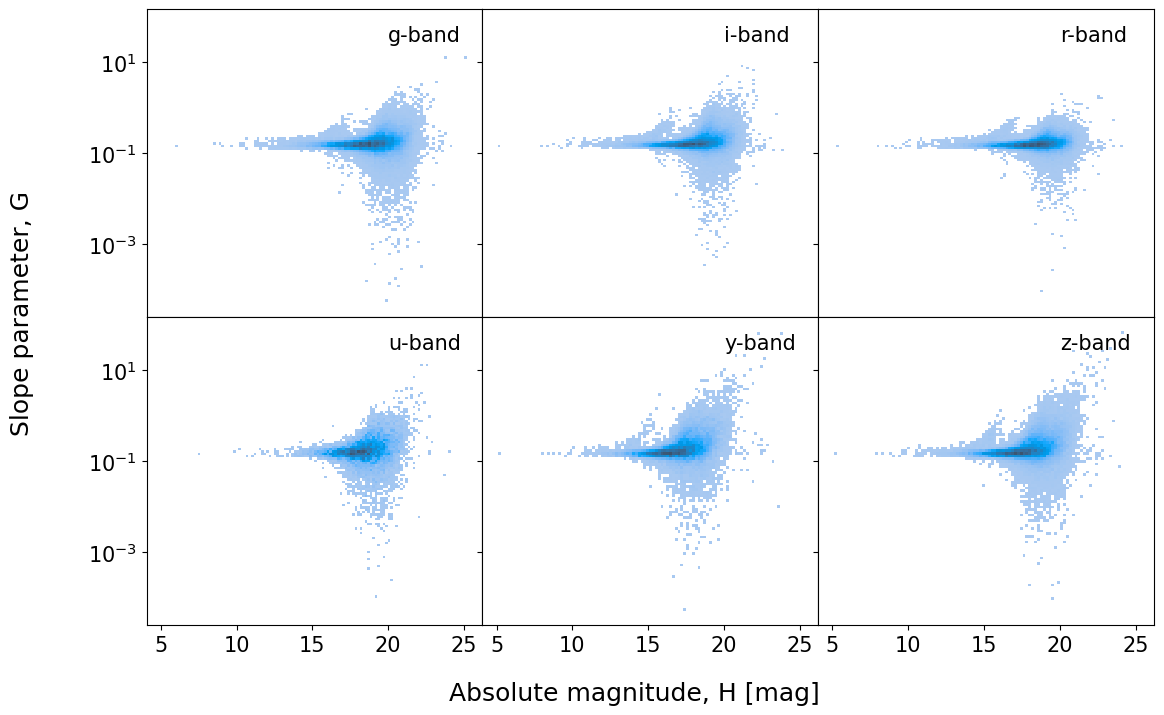

In [372]:
# Plot the G vs H paramters from the two 2-parameter model fits: HG and HG12
fig = plt.figure(figsize=(13,8))
gs = fig.add_gridspec(2, 3, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

for i,ifilt in enumerate(filts):
    sns.histplot(x=res[ifilt+'H'], y=res[ifilt+'G12'], bins=100, log_scale=(False, True), ax=axs[i])
    axs[i].text(20, 30, ifilt+'-band')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)

fig.supxlabel('Absolute magnitude, H [mag]')
fig.supylabel('Slope parameter, G')

### 3.2 Exploration based on numObs (total number) and arc (total baseline in days) of LSST observations

First, we have a look at how phase curve modeling accuracy might depend on "global" measurements (across all filters). For this section we compare total number of observations for a given source (numObs) and the total time baseline across which observations are made (arc of LSST observations) and explore whether or not these factors impact the quality of phase curve modeling. In general, the first plot shows that more observations yields lower uncertainties in the model fits. I have to admit I don't totally understand the second plot comparing uncertainties as a function of time baseline of observations (arc). I am guessing that longer arc does not translate directly to lower uncertainties, since most(?) of the objects in the catalog are distant (fewer sources close to sun?). Since distant objects can have quite long orbits, perhaps the requisite arc for a good fit varies substantially within the population? Maybe this plot would yield better results if the comparison is made after the sample is grouped by heliocentric distance or something.

Text(0.5, 0, 'Arc [days]')

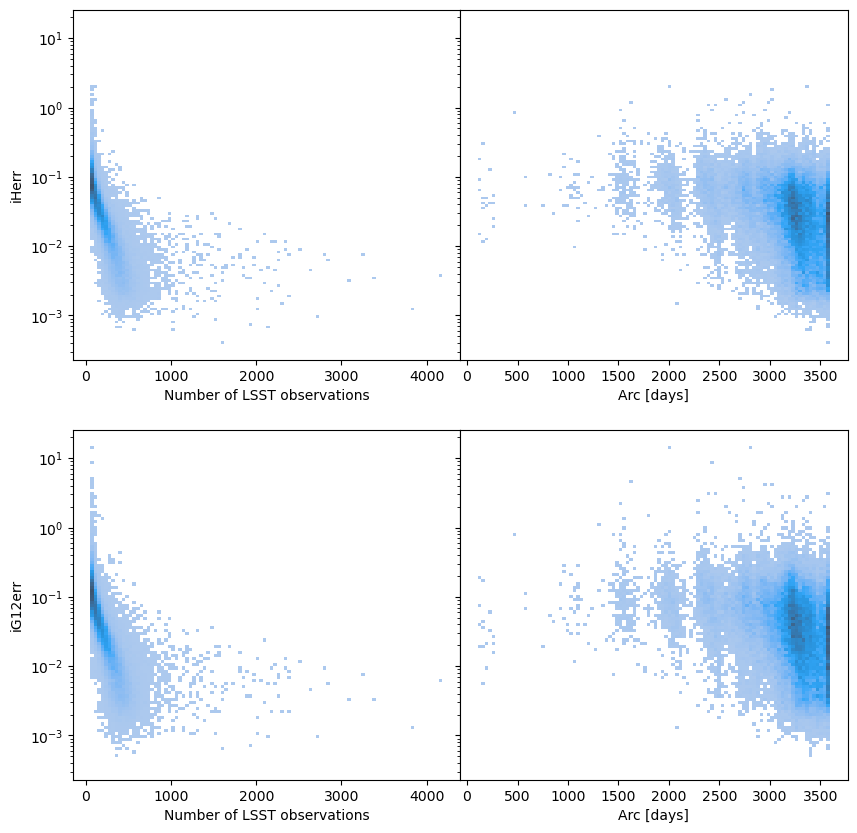

In [40]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 2, wspace=0)
axs = gs.subplots(sharey=True)

# Uncertainty in i-band absolute magnitude vs. Number of LSST observations
sns.histplot(x=res['numObs'], y=res['iHerr'], bins=100, log_scale=(False, True), ax=axs[0,0])
axs[0,0].set_xlabel('Number of LSST observations')

# Uncertainty in i-band absolute magnitude vs. length of arc
sns.histplot(x=res['arc'], y=res['iHerr'], bins=100, ax=axs[0,1])
axs[0,1].set_xlabel('Arc [days]')

# Uncertainty in i-band slope parameter vs. Number of LSST observations
sns.histplot(x=res['numObs'], y=res['iG12err'], bins=100, ax=axs[1,0])
axs[1,0].set_xlabel('Number of LSST observations')

# Uncertainty in i-band slope parameter vs. length of arc
sns.histplot(x=res['arc'], y=res['iG12err'], bins=100, ax=axs[1,1])
axs[1,1].set_xlabel('Arc [days]')

### 3.3 Number of data used per band

The above plots compare numObs (total) with model fits (per band) which may not be the ideal metric since as one can see from the modeling of individual objects in different filters in Section 2.4, the quality of phase curves can vary quite a bit between filters. Instead, we can look at the number of datapoints included in the phase curve modeling on a per filter basis (i.e. rNdata for the r-band in the SSObject Table). Below, we look at the distribution of the number of observations in each filter used to model the phase curve per filter for all SSObjects which in total have more than 100 numObs and arc (as per query above). One can see that generally, r and i bands produce the most data points for recovering phase curves, while u-band produces the fewest. In the second plot, one can see that the 

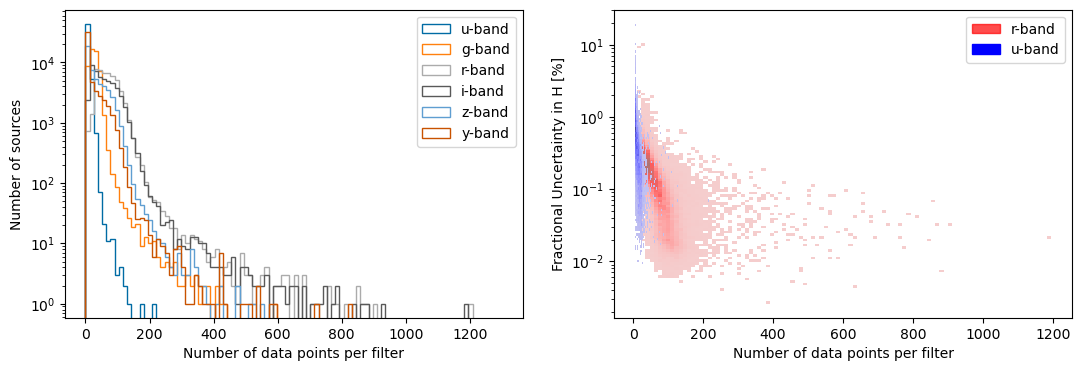

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(13,4))

filters = ['u','g','r','i','z','y']
for i,ifilt in enumerate(filters):
    axs[0].hist(res[ifilt+'Ndata'], bins=100, range=(0,1300), histtype='step', label=ifilt+'-band')
    
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_xlabel('Number of data points per filter')
axs[0].set_ylabel('Number of sources')


sns.histplot(x=res['rNdata'], y=100*res['rHerr']/res['rH'], 
             bins=100, log_scale=(False, True), color='r', alpha=0.7, ax=axs[1])
sns.histplot(x=res['uNdata'], y=100*res['uHerr']/res['uH'], 
             bins=100, log_scale=(False, True), color='b', ax=axs[1])
    
axs[1].set_xlabel('Number of data points per filter')
axs[1].set_ylabel('Fractional Uncertainty in H [%]')
r_patch = mpatches.Patch(color='red', alpha=0.7, label='r-band')
u_patch = mpatches.Patch(color='blue', label='u-band')
axs[1].legend(handles=[r_patch, u_patch])

## Brainstorming additional parameters to use for characterizing the measurements 
These parameters could be useful for the end of section 3, where we explore what measurements we can use that are in df_indivObs and storing a "quality" parameter for them in a new column of df_uniqObj. 

Some ideas to compare uncertainties to (just pick a couple good informative ones): 
- number of observations (done)
- arc (done)
- sso.zNdata (or other filters) = number of datapoints used to fit phase curve (per filter; perhaps less noisy than total number of obs; done)
- Pick mean or median apparent mag photometric uncertainty for the best 68% of measurements? (done)
- mean or median reduced mag uncertainty for best 68% of measurements? (TBD)
- sso.MOID = minimum orbit intersection distance to earth (farther at fixed size means potentially it will stay faint always?) Pedro suggests this will not be a useful metric as it will change a lot and won't be included in 2nd DP0.3 release.
- Pick some median dia.snr = signal to noise ratio at which the source was detected in difference image (TBD)